In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import random
import h5py
import copy
import os
import seaborn as sns

from utils import *
from CLE_funcs import *

random.seed(a=1)

# Figures

In [2]:
title_fontsize = 18
labels_fontsize = 18
ticks_fontsize = 18

global_fontsize = 18
legend_fontsize = 18

# Customizing fonts globally to use Arial (or another sans-serif font)
plt.rcParams.update({
    'font.family': 'sans-serif',  # Choose a sans-serif font
    'font.sans-serif': ['Arial'],  # Set to Arial (if available)
    'font.size': labels_fontsize,  # Adjust default font size
    'axes.titlesize': title_fontsize,  # Title font size
    'axes.labelsize': labels_fontsize,  # Label font size
    'legend.fontsize': legend_fontsize,  # Legend font size
})


In [3]:
NUM_SELECTED_CONDS = 5


BLOCK_NUM = 1

# Define block and condition names
blocks = ['Block1'] 
conditions = [
    'C0_local_random_init', 'C1_local_prev_local_init', 'C2_local_sims_init', 
    'C3_StaticTrial', 'C4_pfa_random_init', 'C5_pfa_sims_init', 
    'C6_pfa_running_random', 'C7_pfa_running_sim'
]
NUM_PLOTTED_CONDITIONS = 8
NUM_PLOTTED_CONDITIONS_WITH_GLOBAL = 10
NUM_CLIENTS = 16

# Idk what the second static is. The first static is FKA None/Trained
condition_name_labels = ['Random', 'Static', 'Open-loop', 'Static', 'Random', 'Open-loop', 'Seq (Random)', 'Seq (Open-loop)']
#'S100', 'S107' removed due to missing/exploding data
my_subjects_lst = ['S101', 'S102', 'S103', 'S104', 'S105', 'S106', 'S108', 'S109', 'S110', 
                   'S111', 'S112', 'S113', 'S114', 'S115', 'S116', 'S117']
assert(NUM_CLIENTS == len(my_subjects_lst))


# Define the desired order for the box plots
boxplot_order = ['Local Random', 'Local Sims', 'PFA Random', 'PFA Sims', 'None']
x_pos_lst = [0, 1, 4, 2, 3]

cond_labels = ["Local Random", "Local Sims", "Static", "PFA Random", "PFA Sims"]
model_inits_lst = ["Random", "Open-loop", "Pretrained", "Random",  "Open-loop"]

block = 1
conditions_names_only_lst = [
    'local_random_init', 'local_prev_local_init', 'local_sims_init', 
    'StaticTrial', 'pfa_random_init', 'pfa_sims_init', 
    'pfa_running_random', 'pfa_running_sim'
]
num_conditions = len(conditions_names_only_lst)

# Define the keys
keys = [ 
    'local_random_init', 'local_prev_local_init', 'local_sims_init', 
    'StaticTrial', 'pfa_random_init', 'pfa_sims_init', 
    'pfa_running_random', 'pfa_running_sim'
]

In [6]:
privacy_df = pd.read_csv('res_datasets\\CLE_privacy_df.csv')

print(privacy_df.shape)
privacy_df.head()


(80, 7)


,Condition Number,Subject_ID,Privacy,x_pos,Condition,Initialization,Algorithm
0,0,S101,0.666667,0,LocalRandom,Random,Local
1,0,S102,0.666667,0,LocalRandom,Random,Local
2,0,S103,1.000000,0,LocalRandom,Random,Local
3,0,S104,0.666667,0,LocalRandom,Random,Local
4,0,S105,0.833333,0,LocalRandom,Random,Local


In [ ]:
performance_df = pd.read_csv('res_datasets\\CLE_cost_df.csv')

print(performance_df.shape)
performance_df.head()


(80, 6)


,Cost,Initialization,x_pos,Condition Name,Algorithm,Subject_ID
0,4.275860,Random,0,local_random_init,Local,0
1,0.722547,Random,0,local_random_init,Local,1
2,34.612309,Random,0,local_random_init,Local,2
3,11.519441,Random,0,local_random_init,Local,3
4,8.024025,Random,0,local_random_init,Local,4


In [8]:
boxplot_order = [1, 4, 2, 3, 0]

In [9]:
dot_size = 1.75
marker_size = 10
err_bar_width = 3
capsize = 0.0


c:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\seaborn\categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)


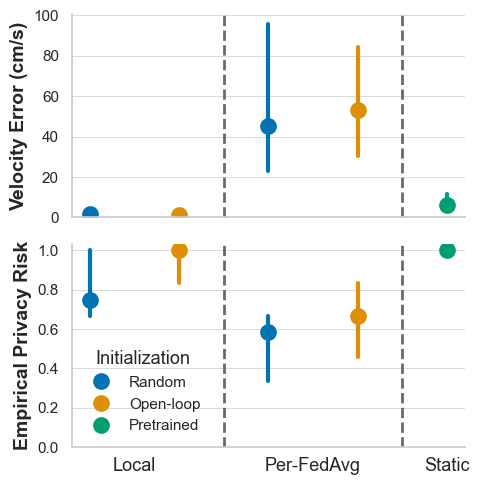

In [10]:

tick_fontsize  = 13
label_fontsize = 16
palette_name   = "colorblind"

sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 1, figsize=(5, 5), sharex=True)

# ── Top: median ± IQR of Cost ───────────────────────────────────────────────────
ax = axs[0]
sns.pointplot(
    x='x_pos', y='Cost', hue='Initialization',
    data=performance_df,
    palette=palette_name,
    estimator=np.median,
    errorbar=('pi', 50),      # use 25th–75th percentile interval (IQR)
    capsize=capsize,
    linestyle='none',
    err_kws={'linewidth': err_bar_width},
    ax=ax, 
    markers='o',
    #scale=dot_size
)
# Set marker size directly via matplotlib
for line in ax.lines:
    line.set_markersize(marker_size) 
ax.set_ylabel("Velocity Error (cm/s)",
              fontweight='bold', fontsize=label_fontsize-2)
ax.tick_params(axis='y', labelsize=tick_fontsize-2)
ax.axvline(x=1.5, color='dimgray', linestyle='--', linewidth=2)
ax.axvline(x=3.5, color='dimgray', linestyle='--', linewidth=2)
for spine in ['top','right']:
    ax.spines[spine].set_visible(False)
ax.grid(True, axis='y', linestyle='-', linewidth=0.5)
ax.get_legend().remove()
ax.set_xticks([])
ax.set_xlabel("")
ax.set_ylim(bottom=0)


# ── Bottom: median ± IQR of Privacy Risk ────────────────────────────────────────
ax = axs[1]
sns.pointplot(
    x='x_pos', y='Privacy', hue='Initialization',
    data=privacy_df,
    palette=palette_name,
    estimator=np.median,
    errorbar=('pi', 50),      # use IQR here too
    capsize=capsize,
    linestyle='none',
    err_kws={'linewidth': err_bar_width},
    ax=ax, 
    markers='o',
    #scale=dot_size
)
# Set marker size directly via matplotlib
for line in ax.lines:
    line.set_markersize(marker_size) 
ax.set_ylabel("Empirical Privacy Risk",
              fontweight='bold', fontsize=label_fontsize-2)
ax.tick_params(axis='y', labelsize=tick_fontsize-2)
ax.axvline(x=1.5, color='dimgray', linestyle='--', linewidth=2)
ax.axvline(x=3.5, color='dimgray', linestyle='--', linewidth=2)
for spine in ['top','right']:
    ax.spines[spine].set_visible(False)
ax.grid(True, axis='y', linestyle='-', linewidth=0.5)

# legend tweaks
legend = ax.legend(loc='lower left', frameon=False)
legend.set_title("Initialization")
legend.get_title().set_fontsize(13)
for text in legend.get_texts():
    text.set_fontsize(11)

ax.set_xticks([])   # remove x‐ticks
ax.set_xlabel("Algorithm")
ax.set_ylim(bottom=0)

# custom algorithm labels
ymin, ymax = ax.get_ylim()
for xpos, label in zip([0.5, 2.5, 4], ['Local','Per-FedAvg','Static']):
    ax.text(xpos, ymin - 0.05*(ymax-ymin), label,
            ha='center', va='top', fontsize=tick_fontsize)

plt.tight_layout()
#plt.savefig('CLE_PrimaryOutcomes_Dots.png', dpi=500, bbox_inches='tight')
plt.show()
